# Acoustic Noise Classifier

A machine learning project for classifying acoustic noise levels in audio signals using MFCC features. This notebook implements and compares Random Forest and Multi-Layer Perceptron (MLP) classifiers for categorizing audio into three noise levels:

- **Class 0: Low Noise** (30-40 dB SNR) - Quiet environments
- **Class 1: Mid Noise** (15-25 dB SNR) - Conversational settings  
- **Class 2: High Noise** (0-10 dB SNR) - Noisy environments

The models are trained on MFCC features extracted from 2-second audio chunks and optimized using hyperparameter tuning.

## Setup and Imports

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from config import (
    FEATURES_PATH, LABELS_PATH, MODEL_PATH, SCALER_PATH, 
    CLASS_LABELS, PLOTS_DIR, create_directories
)
import os

In [ ]:
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title(f'Confusion Matrix ({model_name})')
    plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
    plt.show()


def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=3):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    sns.set(style="whitegrid")
    blues = sns.color_palette("Blues", n_colors=3)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color=blues[1], label="Training score", linewidth=2, markersize=6)
    plt.plot(train_sizes, test_scores_mean, 'o-', color=blues[2], label="Cross-validation score", linewidth=2, markersize=6)

    plt.title(title, fontsize=14)
    plt.xlabel("Training Examples", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend(loc="best", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'learning_curve_{title.lower().replace(" ", "_")}.png', dpi=300)
    plt.show()

## Data Loading and Preparation

Load the preprocessed dataset containing MFCC features extracted from audio chunks.

The dataset should be generated using the `data-preprocessing.py` script.

In [ ]:
create_directories()

print(f"Loading saved dataset from {FEATURES_PATH} and {LABELS_PATH}...")
X = np.load(FEATURES_PATH)
y = np.load(LABELS_PATH)
print("Class distribution:", np.bincount(y))
print(f"Dataset loaded: {len(X)} samples, {X.shape[1]} features each")

Loading saved dataset from X.npy and y.npy...
Class distribution: [24000 24000 24000]
Dataset loaded: 72000 samples, 26 features each


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Random Forest Classifier

### Data Preprocessing and Feature Selection

Split the dataset and apply feature scaling and selection using Recursive Feature Elimination (RFE).

In [ ]:
print("Applying RFE feature selection...")
rfe = RFE(estimator=RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=30, step=10)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

Applying RFE feature selection...


### Hyperparameter Optimization

Set up parameter grid and perform randomized search to find optimal Random Forest hyperparameters.

In [5]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}

rf = RandomForestClassifier(random_state=42)

In [6]:
print("Running RandomizedSearchCV for hyperparameter tuning...")
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)
random_search.fit(X_train_rfe, y_train)

Running RandomizedSearchCV for hyperparameter tuning...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  20.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  20.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  20.9s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  23.0s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  23.2s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  23.7s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  24.4s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  24.8s
[CV] END max_depth=20, max_features=l

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2', 0.5],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Best cross-validation score: 0.8227777777777777


In [ ]:
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_rfe)
print("\n--- Optimized RandomForest ---")
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=["Low Noise", "Mid Noise", "High Noise"]))


--- Optimized RandomForest ---
Test accuracy: 0.8999
              precision    recall  f1-score   support

   Low Noise       0.90      0.93      0.91      4800
   Mid Noise       0.87      0.87      0.87      4800
  High Noise       0.93      0.90      0.91      4800

    accuracy                           0.90     14400
   macro avg       0.90      0.90      0.90     14400
weighted avg       0.90      0.90      0.90     14400



### Random Forest Model Evaluation

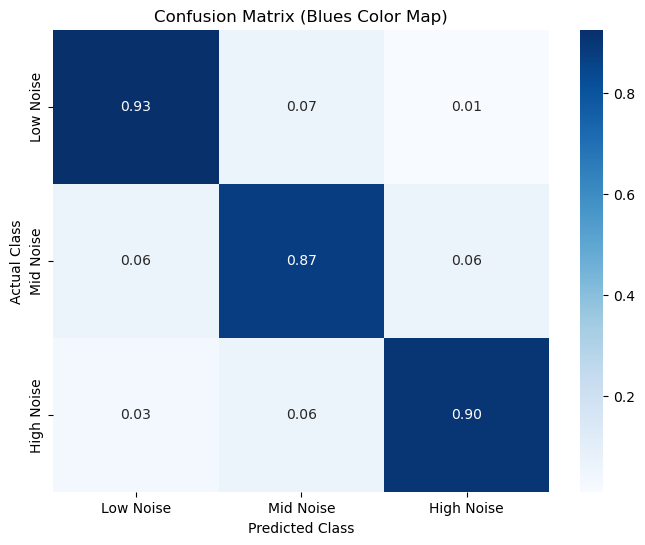

In [9]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Low Noise', 'Mid Noise', 'High Noise'], yticklabels=['Low Noise', 'Mid Noise', 'High Noise'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix (Blues Color Map)')
plt.savefig('confusion_matrix_optimized.png')
plt.show()

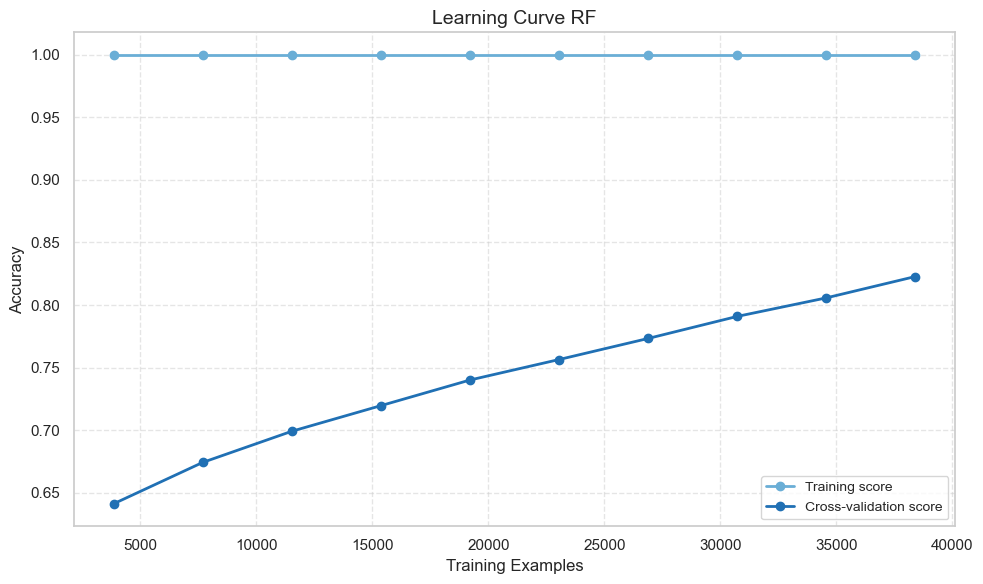

In [14]:
plot_learning_curve(best_rf, X_train_rfe, y_train, title="Learning Curve RF")

In [ ]:
joblib.dump(best_rf, "optimized_rf_classifier.pkl")
joblib.dump(scaler, "rf_scaler.pkl")
joblib.dump(rfe, "rfe_selector.pkl")
print("Models saved as optimized_rf_classifier.pkl, rf_scaler.pkl, and rfe_selector.pkl")

Models saved as optimized_rf_classifier.pkl, rf_scaler.pkl, and rfe_selector.pkl


## Multi-Layer Perceptron (MLP) Classifier

Due to the complexity and large size of the Random Forest model (as reflected in the .pkl file), we explore a Multi-Layer Perceptron (MLP) neural network approach for acoustic noise classification. 

This approach includes hyperparameter optimization and early stopping to improve performance and prevent overfitting.

In [ ]:
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

### MLP Data Preparation

Load dataset and create train/validation/test splits with proper scaling for neural network training.

In [ ]:
print("Loading saved dataset from X.npy and y.npy...")
print("Class distribution:", np.bincount(y))
print(f"Dataset loaded: {len(X)} samples, {X.shape[1]} features each")

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1, random_state=42, stratify=y_train_val
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Loading saved dataset from X.npy and y.npy...
Class distribution: [24000 24000 24000]
Dataset loaded: 72000 samples, 26 features each


### MLP Hyperparameter Tuning

Configure and optimize MLP hyperparameters including network architecture, learning rate, and regularization.

In [ ]:
base_mlp = MLPClassifier(
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
)

param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (200,), (100, 50)],
    'alpha': [1e-4, 1e-3, 1e-2],
    'learning_rate_init': [0.001, 0.01, 0.05],
    'solver': ['adam', 'sgd'],
}

print("Running RandomizedSearchCV...")
search = RandomizedSearchCV(
    base_mlp,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
search.fit(X_train_scaled, y_train)

Running RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=MLPClassifier(early_stopping=True, max_iter=300,
                                           random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01],
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (200,),
                                                               (100, 50)],
                                        'learning_rate_init': [0.001, 0.01,
                                                               0.05],
                                        'solver': ['adam', 'sgd']},
                   scoring='accuracy', verbose=1)

### MLP Model Evaluation and Results

Evaluate the optimized MLP model performance with learning curves, confusion matrix, and classification metrics.

In [4]:
best_mlp = search.best_estimator_
print("Best hyperparameters:", search.best_params_)

Best hyperparameters: {'solver': 'sgd', 'learning_rate_init': 0.05, 'hidden_layer_sizes': (100, 50), 'alpha': 0.01}


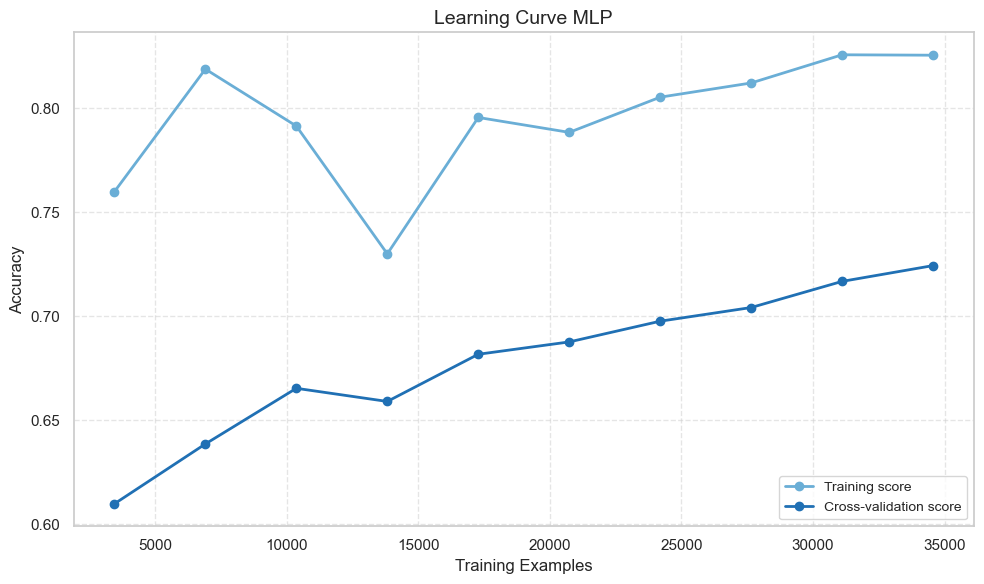


--- Safeguarded Tuned Tiny MLP with All Features ---
Test accuracy: 0.7501
              precision    recall  f1-score   support

   Low Noise       0.76      0.86      0.81      4800
   Mid Noise       0.68      0.65      0.67      4800
  High Noise       0.81      0.74      0.77      4800

    accuracy                           0.75     14400
   macro avg       0.75      0.75      0.75     14400
weighted avg       0.75      0.75      0.75     14400



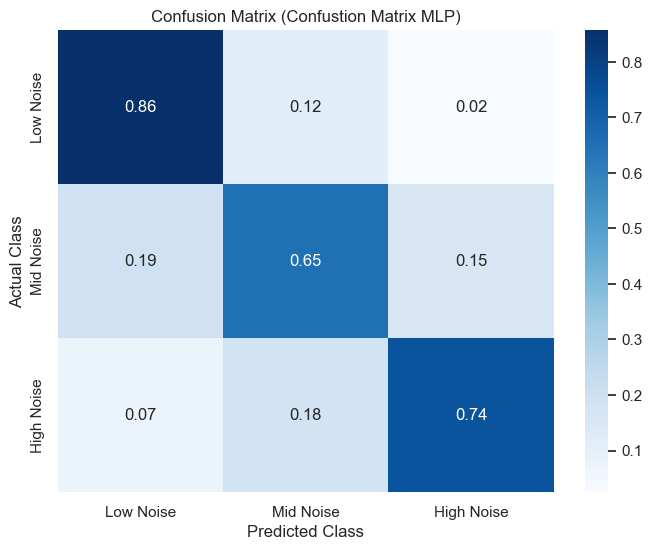

In [8]:
plot_learning_curve(best_mlp, X_train_scaled, y_train, title="Learning Curve MLP")

y_pred_mlp = best_mlp.predict(X_test_scaled)
print("\n--- Safeguarded Tuned Tiny MLP with All Features ---")
print(f"Test accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")
print(classification_report(y_test, y_pred_mlp, target_names=["Low Noise", "Mid Noise", "High Noise"]))
cm_mlp = confusion_matrix(y_test, y_pred_mlp, normalize='true')
plot_confusion_matrix(cm_mlp, ['Low Noise', 'Mid Noise', 'High Noise'], "Confustion Matrix MLP")

In [9]:
joblib.dump(best_mlp, "mlp_model.pkl", compress=3)
joblib.dump(scaler, "mlp_scaler.pkl", compress=3)
print("Models saved as mlp_model.pkl and mlp_scaler.pkl")

Models saved as mlp_model.pkl and mlp_scaler.pkl
